# EvoAvalla, Random and Atgt report file analysis

## Get reports from Github
Upload report files, get data from github repository, just specify experiment number to get files from, if you want to upload files manually skip these two cells or set the filed to 0

In [15]:
# set the experiment number to take files from
# set 0 to skip and upload files manually
experiment_number = 1

In [16]:
# Import the data
import requests
import pandas as pd

if experiment_number > 0:
  # get the reports from GitHub
  folder_path = f"exp_{experiment_number}"
  repo_owner = "asmeta"
  repo_name = "asmeta"
  branch_name = "isaac"
  folder_path = f"code/experimental/asmeta.evotest/asmeta.evotest.experiments/data/exp_{experiment_number}"

  # GitHub URL API
  api_url = f"https://api.github.com/repos/{repo_owner}/{repo_name}/contents/{folder_path}?ref={branch_name}"

  # Github API
  response = requests.get(api_url)
  files = response.json()

  # Download csv files into the workspace
  dataframes = {}
  for file in files:
      if file["name"].endswith(".csv"):
          file_url = file["download_url"]

          file_path = f"/content/{file['name']}"
          with open(file_path, "wb") as f:
              f.write(requests.get(file_url).content)


## Process the benchmark
The benchmark file collects data on the total conditional rules and the total update rules for each specification.

In [17]:
# Set the Benchmark
import pandas as pd

bm = pd.read_csv("benchmark.csv")

benchmark = bm.groupby("asm_name").sum()
benchmark = benchmark.drop(columns=['rule_signature'])
benchmark = benchmark.reset_index()
benchmark = benchmark.set_index("asm_name")
benchmark

,tot_conditional_rules,tot_update_rules
asm_name,,
ATM3v2,21,17
Ascensore,6,7
CashPoint,7,7
Cassaforte,2,2
Certifier_nochoose_noundef,17,28
CoffeeVendingMachineNC,6,2
Contatore_U_DA_H,4,4
Dado,4,9
Ferryman,4,5


## Compare the coverage of each method
perform the comparison graphically, showing for each method the coverage of each specification, then include the overall result and shows the tables of each single report

In [18]:
# Definition of methods used to make the comparison
import matplotlib.pyplot as plt
import numpy as np

def process_report(file_name, benchmark):
    """Processes a report CSV file and returns a DataFrame with coverage data."""
    report = pd.read_csv(file_name)
    report.drop(columns=['tot_conditional_rules', 'tot_update_rules', 'failing_scenarios', 'rule_signature'], inplace=True)
    report['covered_conditional_rules'] = report['covered_true_conditional_rules'] + report['covered_false_conditional_rules']
    report.drop(columns=['covered_true_conditional_rules', 'covered_false_conditional_rules'], inplace=True)
    report = report.groupby(["execution_id", "asm_name"]).sum()
    report_merge = pd.merge(report, benchmark[['tot_conditional_rules', 'tot_update_rules']], left_on='asm_name', right_index=True, how='left')
    report_merge['tot_conditional_rules'] = report_merge['tot_conditional_rules'] * 2
    report_merge['uncovered_conditionale_rules'] = report_merge['tot_conditional_rules'] - report_merge['covered_conditional_rules']
    report_merge['uncovered_update_rules'] = report_merge['tot_update_rules'] - report_merge['covered_update_rules']
    new_order = ['tot_conditional_rules', 'covered_conditional_rules', 'uncovered_conditionale_rules','tot_update_rules', 'covered_update_rules', 'uncovered_update_rules']
    report_merge = report_merge[new_order]
    report_merge['coverage'] = (report_merge['covered_conditional_rules'] +  report_merge['covered_update_rules']) / (report_merge['tot_conditional_rules'] + report_merge['tot_update_rules']) * 100
    return report_merge

def plot_coverage_comparison(csv_files, labels, benchmark):
    """Plot the coverage plot for each csv file based on the benchmark dataframe."""
    fig, axes = plt.subplots(len(csv_files), 1, figsize=(13, 18))  # Vertical arrangement

    all_asm_names = benchmark.index.tolist()
    processed_dfs = [] # List to store processed DataFrames

    for i, file in enumerate(csv_files):
        df = process_report(file, benchmark)

        coverage_values = []
        asm_names = []

        for asm_name in all_asm_names:
            if asm_name in df.index.get_level_values('asm_name'):
                coverage = df.loc[(slice(None), asm_name), 'coverage'].values[0]
            else:
                coverage = 0
            coverage_values.append(coverage)
            asm_names.append(asm_name)

        ax = axes[i]  # Access the current subplot axes
        x_pos = np.arange(len(all_asm_names))
        ax.bar(x_pos, coverage_values, color='green', label='Covered')
        ax.bar(x_pos, 100 - np.array(coverage_values), bottom=coverage_values, color='red', label='Uncovered')

        # Add coverage percentage text annotations
        for j, coverage in enumerate(coverage_values):
          if coverage > 0:  # Only add label if coverage is greater than 0
            ax.text(x_pos[j], coverage / 2, f'{coverage:.1f}%',
                    ha='center', va='center', color='white', fontweight='bold', fontsize=7)

        # Calculate and display additional information
        covered_asm_count = sum(1 for coverage in coverage_values if coverage > 0)
        uncovered_asm_count = sum(1 for coverage in coverage_values if coverage == 0)
        total_rules_covered = df['covered_conditional_rules'].sum() + df['covered_update_rules'].sum()
        total_rules = df['tot_conditional_rules'].sum() + df['tot_update_rules'].sum()
        total_rules_coverage = (total_rules_covered / total_rules) * 100 if total_rules else 0  # Avoid division by zero
        mean_coverage = df['coverage'].mean()

        # Create text annotation for additional information
        info_text = f"Total Rule Coverage: {total_rules_coverage:.1f}%\n" \
                    f"Mean Coverage: {mean_coverage:.1f}%\n" \
                    f"Covered ASMs: {covered_asm_count}\n" \
                    f"Uncovered ASMs: {uncovered_asm_count}"

        # Add text annotation to the subplot
        ax.text(1.02, 0.5, info_text, transform=ax.transAxes, ha='left', va='center')

        ax.set_xlabel('ASM Name')
        ax.set_ylabel('Coverage (%)')
        ax.set_title(f'Coverage for {labels[i]}')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(all_asm_names, rotation=45, ha='right')
        ax.legend()

        processed_dfs.append(df)  # Append the DataFrame to the list

    plt.tight_layout()
    plt.show()

    return processed_dfs

### Graphic comparison

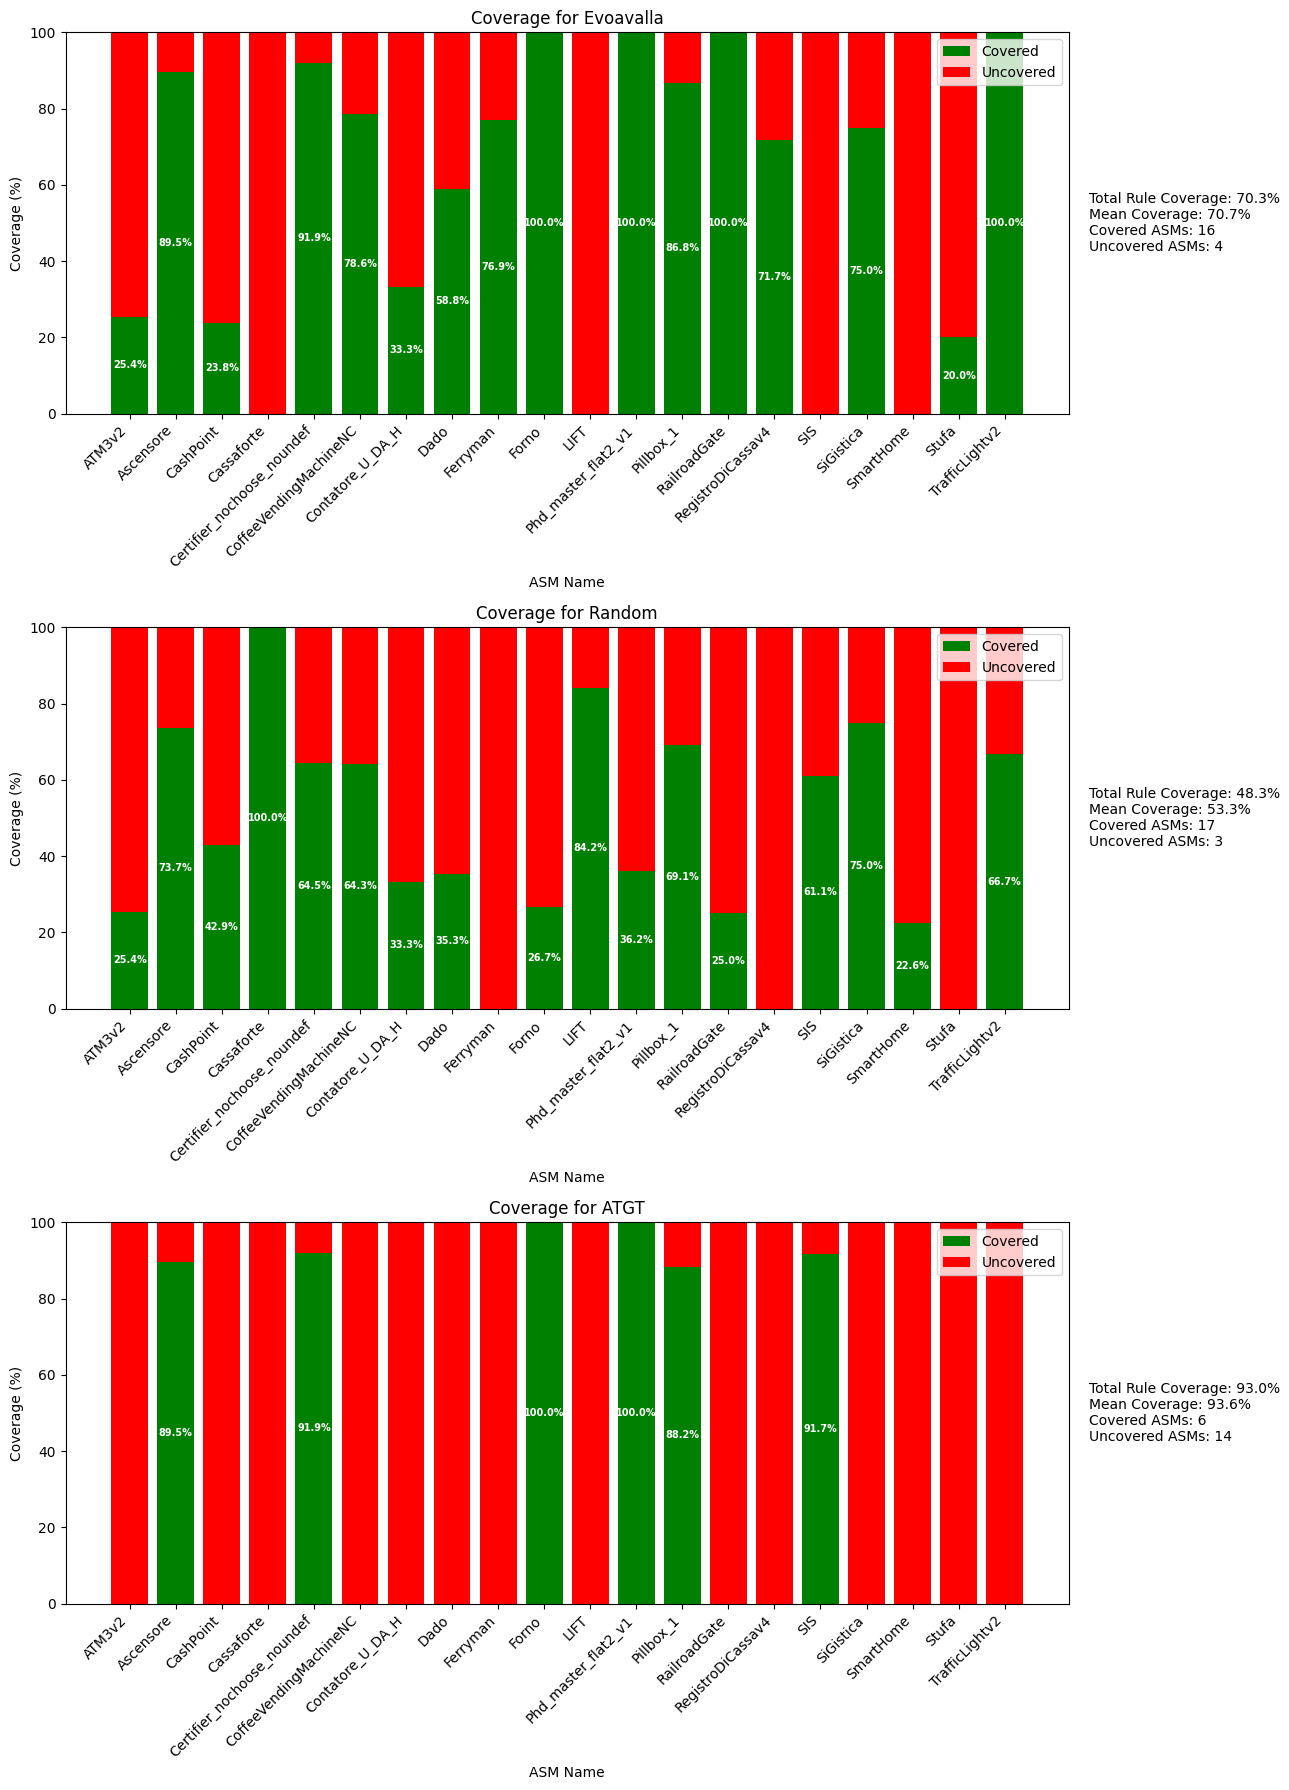

In [19]:
# Perform a graphical comparison regarding the coverage of each method on each asm specification
csv_files = ['report_evoavalla.csv', 'report_random.csv', 'report_atgt.csv']
labels = ['Evoavalla', 'Random', 'ATGT']
processed_dataframes = plot_coverage_comparison(csv_files, labels, benchmark)

### Table comparison

In [20]:
from IPython.display import display

# Display the first DataFrame (excluding execution_id)
print("EvoAvalla report:")
report_evoavalla = processed_dataframes[0].reset_index().drop(columns=['execution_id'])
display(report_evoavalla)
evoavalla_rule_coverage = (report_evoavalla['covered_conditional_rules'].sum() + report_evoavalla['covered_update_rules'].sum() ) / (report_evoavalla['tot_conditional_rules'].sum() + report_evoavalla['tot_update_rules'].sum()) * 100
print(f"Coverage on the total number of rules: {evoavalla_rule_coverage:.1f}%")
evoavalla_mean_coverage = report_evoavalla['coverage'].mean()
print(f"Mean coverage: {evoavalla_mean_coverage:.1f}%")
evoavalla_cover_ratio = f"{len(report_evoavalla[report_evoavalla['coverage'] > 0])}/{len(benchmark)}"
print(f"Cover ratio: {evoavalla_cover_ratio}")

# Display the second DataFrame (excluding execution_id)
print("\nRandom report:")
report_random = processed_dataframes[1].reset_index().drop(columns=['execution_id'])
display(report_random)
random_rule_coverage = (report_random['covered_conditional_rules'].sum() + report_random['covered_update_rules'].sum() ) / (report_random['tot_conditional_rules'].sum() + report_random['tot_update_rules'].sum()) * 100
print(f"Coverage on the total number of rules: {random_rule_coverage:.1f}%")
random_mean_coverage = report_random['coverage'].mean()
print(f"Mean coverage: {random_mean_coverage:.1f}%")
random_cover_ratio = f"{len(report_random[report_random['coverage'] > 0])}/{len(benchmark)}"
print(f"Cover ratio: {random_cover_ratio}")

# Display the third DataFrame (excluding execution_id)
print("\nAtgt report:")
report_atgt = processed_dataframes[2].reset_index().drop(columns=['execution_id'])
display(report_atgt)
atgt_rule_coverage = (report_atgt['covered_conditional_rules'].sum() + report_atgt['covered_update_rules'].sum() ) / (report_atgt['tot_conditional_rules'].sum() + report_atgt['tot_update_rules'].sum()) * 100
print(f"Coverage on the total number of rules: {atgt_rule_coverage:.1f}%")
atgt_mean_coverage = report_atgt['coverage'].mean()
print(f"Mean coverage: {atgt_mean_coverage:.1f}%")
atgt_cover_ratio = f"{len(report_atgt[report_atgt['coverage'] > 0])}/{len(benchmark)}"
print(f"Cover ratio: {atgt_cover_ratio}")

EvoAvalla report:


,asm_name,tot_conditional_rules,covered_conditional_rules,uncovered_conditionale_rules,tot_update_rules,covered_update_rules,uncovered_update_rules,coverage
0,ATM3v2,42,12,30,17,3,14,25.423729
1,Ascensore,12,10,2,7,7,0,89.473684
2,CashPoint,14,3,11,7,2,5,23.809524
3,Certifier_nochoose_noundef,34,31,3,28,26,2,91.935484
4,CoffeeVendingMachineNC,12,9,3,2,2,0,78.571429
5,Contatore_U_DA_H,8,3,5,4,1,3,33.333333
6,Dado,8,4,4,9,6,3,58.823529
7,Ferryman,8,6,2,5,4,1,76.923077
8,Forno,8,8,0,7,7,0,100.000000
9,Phd_master_flat2_v1,6,6,0,52,52,0,100.000000


Coverage on the total number of rules: 70.3%
Mean coverage: 70.7%
Cover ratio: 16/20

Random report:


,asm_name,tot_conditional_rules,covered_conditional_rules,uncovered_conditionale_rules,tot_update_rules,covered_update_rules,uncovered_update_rules,coverage
0,ATM3v2,42,12,30,17,3,14,25.423729
1,Ascensore,12,9,3,7,5,2,73.684211
2,CashPoint,14,7,7,7,2,5,42.857143
3,Cassaforte,4,4,0,2,2,0,100.000000
4,Certifier_nochoose_noundef,34,22,12,28,18,10,64.516129
5,CoffeeVendingMachineNC,12,7,5,2,2,0,64.285714
6,Contatore_U_DA_H,8,3,5,4,1,3,33.333333
7,Dado,8,2,6,9,4,5,35.294118
8,Forno,8,4,4,7,0,7,26.666667
9,LIFT,8,8,0,11,8,3,84.210526


Coverage on the total number of rules: 48.3%
Mean coverage: 53.3%
Cover ratio: 17/20

Atgt report:


,asm_name,tot_conditional_rules,covered_conditional_rules,uncovered_conditionale_rules,tot_update_rules,covered_update_rules,uncovered_update_rules,coverage
0,Ascensore,12,10,2,7,7,0,89.473684
1,Certifier_nochoose_noundef,34,31,3,28,26,2,91.935484
2,Forno,8,8,0,7,7,0,100.000000
3,Phd_master_flat2_v1,6,6,0,52,52,0,100.000000
4,Pillbox_1,38,34,4,30,26,4,88.235294
5,SIS,22,20,2,14,13,1,91.666667


Coverage on the total number of rules: 93.0%
Mean coverage: 93.6%
Cover ratio: 6/20


## In-depth comparison of individual specifications
Take the specifications on which we have data from all three methods and analyze the coverage specifically

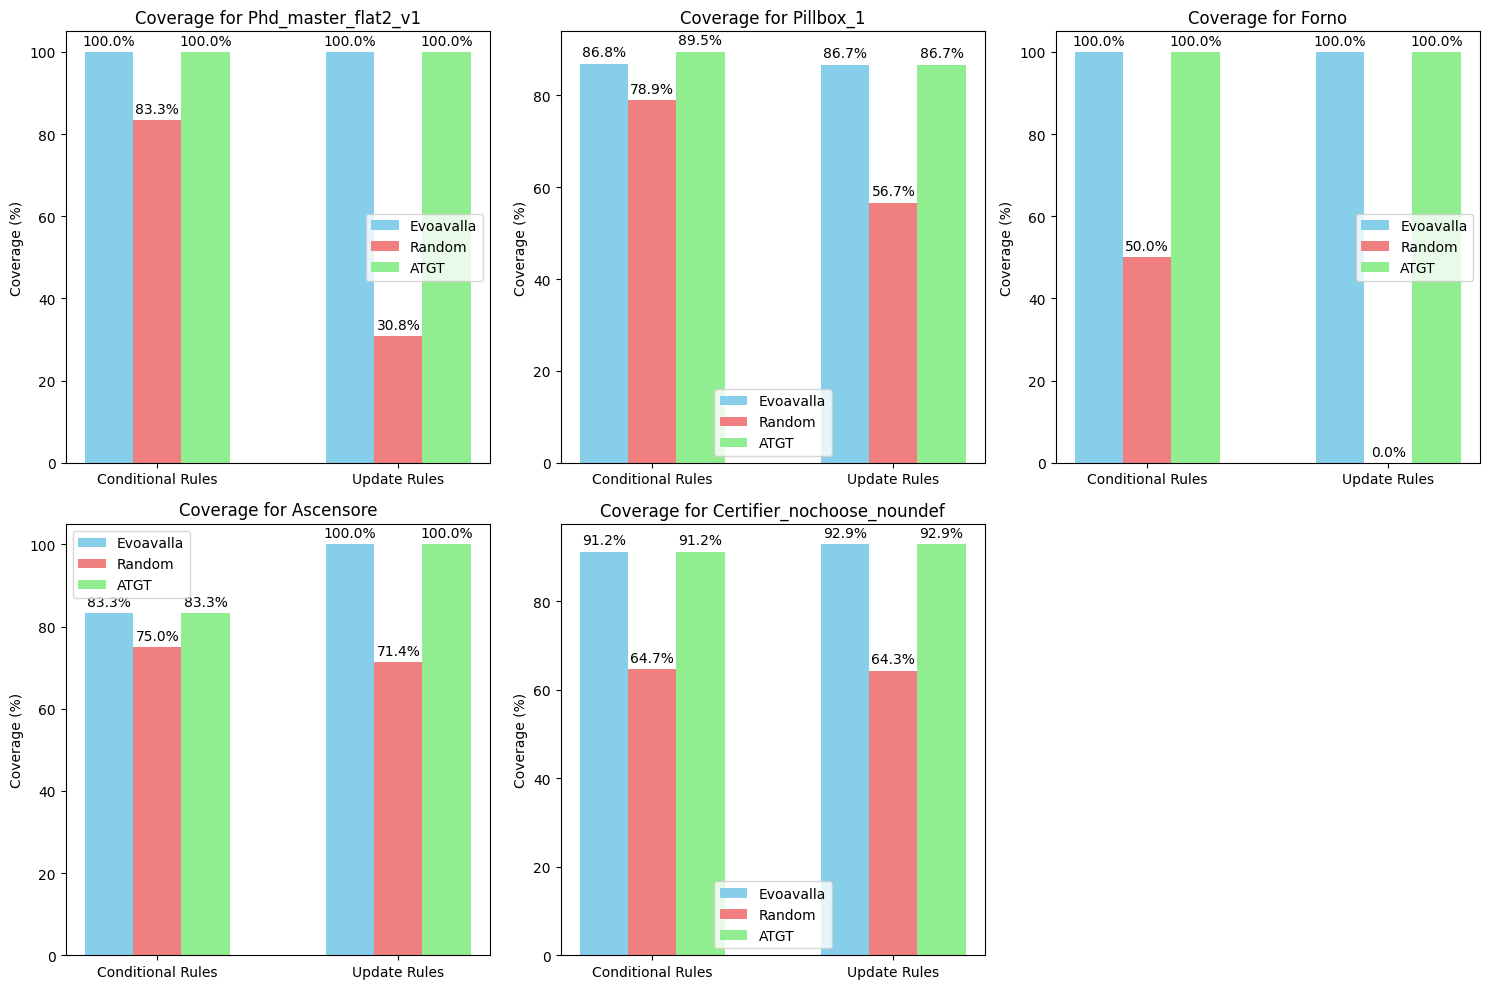

In [21]:

def plot_asm_coverage(ax, asm_name, report_evoavalla, report_random, report_atgt):
    """Plots the coverage and uncovered rules for a given ASM name across three reports."""

    # Extract data for the given ASM name from each report
    data_evoavalla = report_evoavalla[report_evoavalla['asm_name'] == asm_name].iloc[0]
    data_random = report_random[report_random['asm_name'] == asm_name].iloc[0]
    data_atgt = report_atgt[report_atgt['asm_name'] == asm_name].iloc[0]

    # Data for plotting
    categories = ['Conditional Rules', 'Update Rules']
    reports = ['Evoavalla', 'Random', 'ATGT']

    # Calculate coverage percentages
    evoavalla_coverage = [
        data_evoavalla['covered_conditional_rules'] / data_evoavalla['tot_conditional_rules'] * 100,
        data_evoavalla['covered_update_rules'] / data_evoavalla['tot_update_rules'] * 100
    ]
    random_coverage = [
        data_random['covered_conditional_rules'] / data_random['tot_conditional_rules'] * 100,
        data_random['covered_update_rules'] / data_random['tot_update_rules'] * 100
    ]
    atgt_coverage = [
        data_atgt['covered_conditional_rules'] / data_atgt['tot_conditional_rules'] * 100,
        data_atgt['covered_update_rules'] / data_atgt['tot_update_rules'] * 100
    ]

    # Create plot
    x = np.arange(len(categories))
    width = 0.2

    # Plot bars for each report and rule type
    ax.bar(x - width, evoavalla_coverage, width, label='Evoavalla', color='skyblue')
    ax.bar(x, random_coverage, width, label='Random', color='lightcoral')
    ax.bar(x + width, atgt_coverage, width, label='ATGT', color='lightgreen')

    # Add percentage labels on top of bars
    for i, report_coverage in enumerate([evoavalla_coverage, random_coverage, atgt_coverage]):
        for j, coverage in enumerate(report_coverage):
            ax.text(x[j] + (i - 1) * width, coverage + 1, f'{coverage:.1f}%', ha='center', va='bottom')

    # Set plot labels and title
    ax.set_ylabel('Coverage (%)')
    ax.set_title(f'Coverage for {asm_name}')
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.legend()


# Get common ASM names in all three reports
common_asm_names = list(set(report_evoavalla['asm_name']) & set(report_random['asm_name']) & set(report_atgt['asm_name']))

# Determine grid dimensions for subplots
num_asms = len(common_asm_names)
num_cols = 3  # Adjust the number of columns as needed
num_rows = (num_asms + num_cols - 1) // num_cols

# Create a figure and a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))  # Adjust figsize as needed

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each ASM's coverage in a separate subplot
for i, asm_name in enumerate(common_asm_names):
    plot_asm_coverage(axes[i], asm_name, report_evoavalla, report_random, report_atgt)

# Hide any unused subplots
for i in range(num_asms, num_rows * num_cols):
    axes[i].axis('off')

# Adjust layout and display the figure
plt.tight_layout()
plt.show()

## Analyze the distribution of time

### Report table analysis

In [22]:
execution_time = pd.read_csv("execution_time.csv")

# Convert execution time columns to seconds
for column in ['EvoAvalla', 'Random', 'Atgt']:  # Specify the columns to convert
    execution_time[column] = execution_time[column] / 1000  # convert to seconds

execution_time

,AsmSpec,EvoAvalla,Random,Atgt
0,Ascensore,83.428,0.054,2.855
1,ATM3v2,151.805,0.193,0.000
2,CashPoint,143.722,0.043,0.000
3,Cassaforte,80.447,0.174,0.000
4,Certifier_nochoose_noundef,83.213,0.101,4.283
5,CoffeeVendingMachineNC,78.825,0.028,0.000
6,Contatore_U_DA_H,75.027,0.000,0.000
7,Dado,87.021,0.058,0.000
8,Ferryman,80.197,0.046,0.000
9,Forno,80.636,0.064,0.594


### Box plot analysis

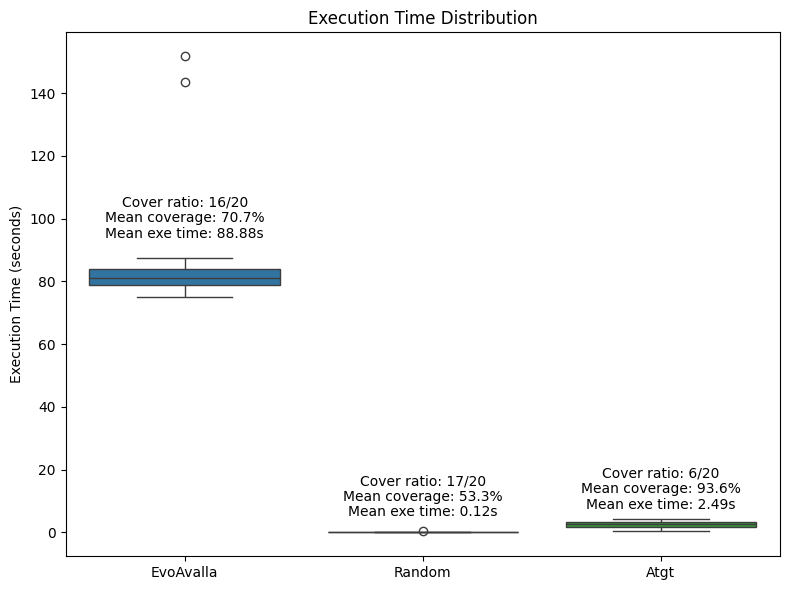

In [23]:
import seaborn as sns

# Create separate lists for each distribution, excluding 0 values
evoavalla_data = execution_time['EvoAvalla'][execution_time['EvoAvalla'] != 0].tolist()
random_data = execution_time['Random'][execution_time['Random'] != 0].tolist()
atgt_data = execution_time['Atgt'][execution_time['Atgt'] != 0].tolist()

# Create the boxplot using seaborn with separate lists
plt.figure(figsize=(8, 6))
ax = sns.boxplot(data=[evoavalla_data, random_data, atgt_data], showmeans=False)

# Calculate and add mean labels
means = [np.mean(evoavalla_data), np.mean(random_data), np.mean(atgt_data)]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], means[tick] + 5, f"Mean exe time: {means[tick]:.2f}s",
            horizontalalignment='center', size='medium', color='black', weight='normal')

# Create coverage labels
coverage_labels = [
    f"Mean coverage: {evoavalla_mean_coverage:.1f}%",
    f"Mean coverage: {random_mean_coverage:.1f}%",
    f"Mean coverage: {atgt_mean_coverage:.1f}%"
]

# Add coverage labels to the plot
for i, label in enumerate(coverage_labels):
    ax.text(i, means[i] + 10, label,
            horizontalalignment='center', size='medium', color='black', weight='normal')

# Create cover ratio asm labels
cover_ratio_asm_labels = [
    f"Cover ratio: {evoavalla_cover_ratio}",
    f"Cover ratio: {random_cover_ratio}",
    f"Cover ratio: {atgt_cover_ratio}"
]

# Add coverage labels to the plot
for z, label in enumerate(cover_ratio_asm_labels):
    ax.text(z, means[z] + 15, label,
            horizontalalignment='center', size='medium', color='black', weight='normal')

# Customize the plot
plt.xticks(ticks=[0, 1, 2], labels=['EvoAvalla', 'Random', 'Atgt'])  # Set x-axis labels
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time Distribution')
plt.tight_layout()
plt.show()